In [1]:
from functools import partial
import matplotlib.pyplot as plt

import jax
from jax.api import jit, grad, vmap
from jax import random
from jax.experimental import optimizers
import jax.numpy as jnp
import jax.scipy.stats.norm as norm

from jax_lensing.inversion import ks93inv

from lenspack.peaks import find_peaks2d
from lenspack.utils import bin2d

from astropy.table import Table

#from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

tfd = tfp.distributions

In [2]:
def plot_convergence(kappaE, x, y, title=''):
    # Plot peak positions over the convergence
    fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))
    mappable = ax.imshow(kappaE, origin='lower', cmap='bone')
    ax.scatter(y, x, s=10, c='orange')  # reverse x and y due to array indexing
    ax.set_axis_off()
    fig.colorbar(mappable)
    plt.title(title)

In [3]:
# ========= Functions to define the evidence lower bound. =========

def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return tfd.MultivariateNormalDiag(mean, jnp.exp(log_std)).sample(seed=rng)

# ========= Define the log-likelihood =========

def log_likelihood(z):
    
    # Import the galaxy catalog
    cat = Table.read('../data/gal_cat.fits')
    e1map, e2map = bin2d(cat['ra'], cat['dec'], v=(-cat['gamma1'], -cat['gamma2']), npix=128)
    x = jnp.stack([e1map,e2map], axis=0).flatten()

    z1, z2 = z[:z.shape[0]//2], z[z.shape[0]//2:]

    kE, kB = jnp.reshape(z1, (128, 128)), jnp.reshape(z2, (128, 128))
    gamma1, gamma2 = ks93inv(kE, kB)

    mean = jnp.stack([gamma1,gamma2], axis=0).flatten()
    dist = tfd.MultivariateNormalDiag(mean, jnp.ones(mean.shape))
    
    return dist.log_prob(x)

In [4]:
# ========= Explicit the KL divergence =========

def gaussian_kl(mean, log_std):
    q = tfd.MultivariateNormalDiag(mean, jnp.exp(log_std)) # approximate distribution
    p = tfd.MultivariateNormalDiag(jnp.zeros(mean.shape), jnp.ones(mean.shape)) # prior
    return q.kl_divergence(p)

# ========= Define the Evidence lower bound =========

def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return  logprob(sample) - gaussian_kl(mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *params))

In [5]:
num_samples = 1 # batch size ?

@jit
def objective(params, t):
    rng = random.PRNGKey(t)
    return -batch_elbo(log_likelihood, rng, params, num_samples)

# Set up optimizer.
D = 2 * 128 * 128

init_mean = jnp.zeros(D)
init_log_std  = jnp.ones(D)
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.sgd(0.0001)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    #print('gradient', gradient)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in range(10000):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    if t%1000==0:
        print('step', t)


Optimizing variational parameters...
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000


In [6]:
#print(params[1])
kappa = params[0]
kE, kB = kappa[:kappa.shape[0]//2], kappa[kappa.shape[0]//2:]
kE, kB = jnp.reshape(kE, (128, 128)), jnp.reshape(kB, (128, 128))

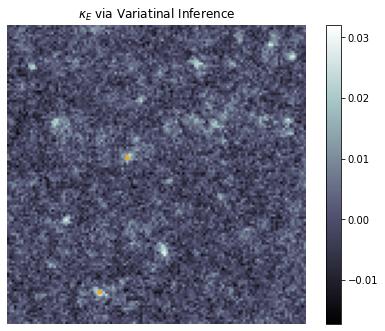

In [7]:
x, y, h = find_peaks2d(kE, threshold=0.03, include_border=True)
# Plot peak positions over the convergence
plot_convergence(kE, x, y, title='$\kappa_E$ via Variatinal Inference')

plt.show()

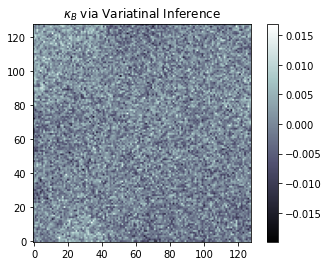

In [8]:
plt.imshow(kB, origin='lower', cmap='bone')
plt.colorbar()
plt.title('$\kappa_B$ via Variatinal Inference')
plt.show()

In [9]:
#print(params[1])
std = jnp.exp(params[1])
stdE, stdB = std[:std.shape[0]//2], std[std.shape[0]//2:]
stdE, stdB = jnp.reshape(stdE, (128, 128)), jnp.reshape(stdB, (128, 128))

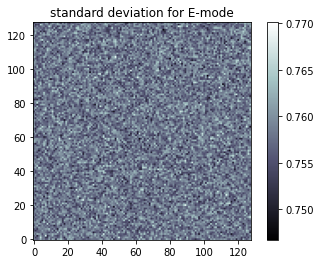

In [11]:
plt.imshow(stdE, origin='lower', cmap='bone')
plt.title('standard deviation for E-mode')
plt.colorbar()